In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as trii
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
file = open("/content/npeltr4.dat.txt")
lines = [i.split('\n')[0] for i in file]
line = [i.split(' ') for i in lines]
dictionary = {'A': [], 'B': [], 'C': []}

lin = []
for index, l in enumerate(line):
  lin.append([])
  for el in l:
    if el is not '':
      lin[index].append(el)

for index, l in enumerate(lin):
    dictionary['A'].append(l[0])
    dictionary['B'].append(l[1])
    dictionary['C'].append(l[2])

df = pd.DataFrame.from_dict(dictionary)
df.to_csv('npeltr4.csv')

In [ ]:
node_file = pd.read_csv('/content/npeltr4.csv', header=None).to_numpy()
element_file = pd.read_csv('/content/epeltr4.csv', header=None).to_numpy()
bc_file = pd.read_csv('/content/bpeltr4.csv', header=None).to_numpy()
hr_file = pd.read_csv('/content/ppeltr4.csv', header=None).to_numpy()

In [ ]:
class element_id:
  def __init__(self, element, node_file, heating_file):
    self.element = element
    self.number = self.element[0]
    self.material = self.element[5]

    self.nodes = []
    self.heat = heating_file[self.element[0] - 1][2]

    self.dy1 = None; self.dy2 = None; self.dy3 = None
    self.dx1 = None; self.dx2 = None ;self.dx3 = None
    self.area = None; self.matrix = []

    self.dphi = []; self.dphide = []; self.dphidz = []; self.dphidx = []
    self.dxde = 0; self.dxdz = 0; self.dyde = 0; self.dydz = 0; self.dphidy = []
    self.phi = []; self.W = 1; self.rhs = []

    self.nodes = []
    nodes = []
    for i in range(1, 5):
      nodes.append(self.element[i])

    if nodes[2] == nodes[3]:
      self.element_type = 'triangle'

      # exclude last node
      for i in range(1, 4):
        self.nodes.append(self.element[i])

    else:
      self.element_type = 'quadrilateral'
      for i in range(1, 5):
        self.nodes.append(self.element[i])

    self.pos = []
    for index, nd in enumerate(self.element):
      param = 5 if  self.element_type == 'quadrilateral' else 4
      if 0 < index < param:
        the_node = nd - 1
        self.pos.append([node_file[the_node][1], node_file[the_node][2]])
    if self.material == 3:
      self.k = 0.210
      self.m = 200.0
    elif self.material == 4:
      self.k = 0.642
      self.m = 2001.4
    elif self.material == 5:
      self.k = 0.436
      self.m = 0.0
    elif self.material == 6:
      self.k = 0.561
      #self.m = 2001.4/2
      self.m = 0.0
    elif self.material == 7:
      self.k = 0.515
      self.m = 1482.5
    elif self.material == 8:
      self.k = 0.642
      self.m = 0.0

  def elem_area(self):

    if self.element_type == 'triangle':
      x1 = self.pos[0][0]
      y1 = self.pos[0][1]

      x2 = self.pos[1][0]
      y2 = self.pos[1][1]

      x3 = self.pos[2][0]
      y3 = self.pos[2][1]

      self.dy1 = y2 - y3
      self.dy2 = y3 - y1
      self.dy3 = y1 - y2

      self.dx1 = x2 - x3
      self.dx2 = x3 - x1
      self.dx3 = x1 - x2

      self.area = 0.5 * (x1 * self.dy1 + x2 * self.dy2 + x3 * self.dy3)
  def calc(self, E, Z):
    phis = []
    dphidxs = []
    dphidys = []
    dphidzs = []
    dphides = []
    dphidxs = []
    dphidys = []
    dxde = 0
    dxdz = 0
    dyde = 0
    dydz = 0
    DJ = []

    phis.append((1 - Z) * (1 - E) * 0.25)
    phis.append((1 + Z) * (1 - E) * 0.25)
    phis.append((1 + Z) * (1 + E) * 0.25)
    phis.append((1 - Z) * (1 + E) * 0.25)

    dphidzs.append(-(1 - E) * 0.25)
    dphidzs.append((1 - E) * 0.25)
    dphidzs.append((1 + E) * 0.25)
    dphidzs.append(-(1 + E) * 0.25)

    dphides.append(-(1 - Z) * 0.25)
    dphides.append(-(1 + Z) * 0.25)
    dphides.append((1 + Z) * 0.25)
    dphides.append((1 - Z) * 0.25)

    for i in range(4):
      dxde += self.pos[i][0] * dphides[i]
      dxdz += self.pos[i][0] * dphidzs[i]
      dyde += self.pos[i][1] * dphides[i]
      dydz += self.pos[i][1] * dphidzs[i]

    DJ = dxdz * dyde - dxde * dydz

    for index, node in enumerate(self.nodes):
        dphidxs.append((dyde * dphidzs[index] - dydz * dphides[index]) / DJ)
        dphidys.append((-dxde * dphidzs[index] + dxdz * dphides[index]) / DJ)

    return phis,dphidxs,dphidys, DJ


  def matrix_f(self):

    self.elem_area()

    # Linear Triangles
    if self.element_type == 'triangle':

      ys = [self.dy1, self.dy2, self.dy3]
      xs = [self.dx1, self.dx2, self.dx3]

      for index, ya in enumerate(ys):
        self.matrix.append([])

        for bindex, yb in enumerate(ys):
          xa = xs[index]; xb = xs[bindex]
          denom = 6 if index == bindex else 12
          self.matrix[index].append((self.k * (-ya * yb - xa * xb) / (4 * self.area)) + ((-self.m) * self.area / denom))

        self.rhs.append(-self.heat * self.area / 3)


    # Quadrilaterals
    if self.element_type == 'quadrilateral':
      num = 0.57735027
      E = [-num, -num, num, num]
      Z = [-num, num, num, -num]
      self.matrix = np.zeros((4, 4))
      self.rhs = np.zeros((4,))
      for index, node in enumerate(self.nodes):
        self.phi, self.dphidx, self.dphidy, self.DJ = self.calc(E[index], Z[index])

        # Gauss point matrix
        for i in range(4):
          for j in range(4):
            self.matrix[i, j] += self.DJ * self.W * (-self.k * (self.dphidx[i] * self.dphidx[j] + self.dphidy[i] * self.dphidy[j])
                                                      - self.m * self.phi[i] * self.phi[j])
          self.rhs[i] += -self.DJ * self.heat * self.W * self.phi[i]

    self.matrix = np.array(self.matrix)
    self.rhs = np.array(self.rhs)

In [ ]:
class node:
  def __init__(self, node, node_file, bc_file):
    self.node = node
    self.x = node_file[self.node - 1][0]
    self.y = node_file[self.node - 1][1]

    if self.node in bc_file[:, 1]:
      self.node_type = 'boundary'

      bc_index = np.argwhere(bc_file[:, 1] == self.node)[0][0]
      self.neighbor1 = bc_file[bc_index][3]
      self.neighbor2 = bc_file[bc_index][4]

      self.h = bc_file[bc_index][5]
      self.Ta = bc_file[bc_index][6]

    else:
      self.node_type = 'interior'

In [ ]:
global_m = np.zeros((len(node_file), len(node_file)))
b = np.zeros((len(node_file),))

for index in range(len(element_file)):
  element = element_id(element_file[index], node_file, hr_file)
  element.matrix_f()

  for i, nodei in enumerate(element.nodes):
    for j, nodej in enumerate(element.nodes):
      global_m[nodei - 1, nodej - 1] += element.matrix[i, j]

    b[nodei - 1] += element.rhs[i]

# boundaries
typeI = False
for index in range(len(node_file)):
  nd = node(index + 1, node_file, bc_file)

  if nd.node_type == 'boundary':

    if not typeI:
      # h and Ta are the same for all nodes so aI = aII = a
      Ta = nd.Ta
      h = nd.h
      a = h
      c = h * Ta

      # distance b/n neighbor1 and node = LI
      neighbor1 = node(int(nd.neighbor1), node_file, bc_file)
      neighbor2 = node(int(nd.neighbor2), node_file, bc_file)

      LI = np.sqrt(((nd.x - neighbor1.x)**2) + ((nd.y - neighbor1.y)**2))
      LII = np.sqrt(((nd.x - neighbor2.x)**2) + ((nd.y - neighbor2.y)**2))

      b[nd.node - 1] += -c * (LI + LII) / 2

      global_m[nd.node - 1, int(nd.neighbor1) - 1] += -a * LI / 6
      global_m[nd.node - 1, nd.node - 1] += -a * (LI + LII) / 3
      global_m[nd.node - 1, int(nd.neighbor2) - 1] += -a * LII / 6

    else:
      b[nd.node - 1] = 0

      global_m[nd.node - 1, :] = 0
      global_m[nd.node - 1, nd.node - 1] = 1

solv = np.linalg.solve(global_m, b)

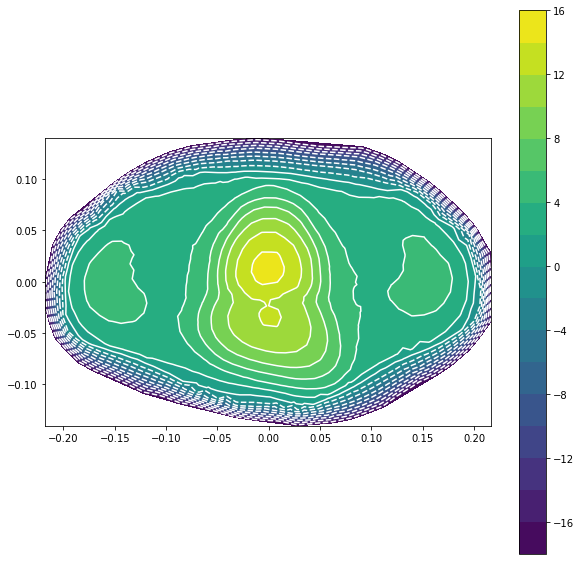

In [ ]:
elem = [element_id(element_file[i], node_file, hr_file).pos for i in range(len(element_file))]
fig, ax = plt.subplots()

x = node_file[:, 1]
y = node_file[:, 2]

for i in elem:
  coord = i.copy()
  coord.append(coord[0])
  xs, ys = zip(*coord)

  # ax.plot(xs, ys, c='black')

C = ax.tricontourf(x, y, solv, levels=15)
fig.colorbar(C)
ax.tricontour(x, y, solv, colors='white', levels=15)
ax.set_aspect('equal')


